In [1]:
#!pip install mkl-service
#!pip install pymc3

In [2]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
import pandas as pd
import pymc as pm
from scipy import stats
from patsy import bs, dmatrix
import pytensor
import pytensor.tensor as pt
import scipy as sp
import scipy.stats as st
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse
from pymc.math import logsumexp
from pymc.variational.callbacks import CheckParametersConvergence
import datetime
from datetime import datetime
from datetime import timedelta
from dateutil.parser import parse

import scipy.fftpack
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import pymc3 as pm
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import matplotlib.dates as mdates
import xarray as xr


#Load Data

In [3]:
country_temp = pd.read_csv("GlobalLandTemperaturesByCountry.csv")

#EDA

In [4]:
country_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [5]:
country_temp.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,544811.000000,545550.000000
mean,17.193354,1.019057
std,10.953966,1.201930
min,-37.658000,0.052000
25%,10.025000,0.323000
50%,20.901000,0.571000
75%,25.814000,1.206000
max,38.842000,15.003000


In [6]:
country_temp

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
...,...,...,...,...
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe
577460,2013-08-01,19.759,0.717,Zimbabwe


In [7]:
country_temp.isnull().sum()

dt                                   0
AverageTemperature               32651
AverageTemperatureUncertainty    31912
Country                              0
dtype: int64

In [8]:
country_temp.shape

(577462, 4)

In [9]:
us_temp = country_temp[country_temp['Country'].isin(['United States'])]

In [10]:
us_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
554880,1768-09-01,15.420,2.880,United States
554881,1768-10-01,8.162,3.386,United States
554882,1768-11-01,1.591,3.783,United States
554883,1768-12-01,-2.882,4.979,United States
554884,1769-01-01,-3.952,4.856,United States


#Data Cleaning/Processing

FillNA - AverageTemperatureUncertainty

In [11]:
from sklearn.impute import SimpleImputer

# Create a SimpleImputer object
imputer = SimpleImputer(strategy='mean')

us_temp['AverageTemperatureUncertainty'] = imputer.fit_transform(us_temp[['AverageTemperatureUncertainty']])

<ipython-input-11-b6b0be15b085>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_temp['AverageTemperatureUncertainty'] = imputer.fit_transform(us_temp[['AverageTemperatureUncertainty']])


FillNA - AverageTemperature

In [12]:
# Assuming 'us_temp' is your DataFrame and 'AverageTemperatureUncertainty' is the column name
min_value = us_temp['AverageTemperatureUncertainty'].min()
max_value = us_temp['AverageTemperatureUncertainty'].max()

# Rescale the column to range from 0 to 1
us_temp['AverageTemperatureUncertainty'] = (us_temp['AverageTemperatureUncertainty'] - min_value) / (max_value - min_value)


<ipython-input-12-6d10e49322c6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_temp['AverageTemperatureUncertainty'] = (us_temp['AverageTemperatureUncertainty'] - min_value) / (max_value - min_value)


In [13]:
us_temp['AverageTemperature']= us_temp['AverageTemperature'].interpolate(method='linear')

<ipython-input-13-4ee5fd21d919>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_temp['AverageTemperature']= us_temp['AverageTemperature'].interpolate(method='linear')


In [14]:
us_temp.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,2941.000000,2941.000000
mean,10.029414,0.147270
std,9.103199,0.161624
min,-7.581000,0.000000
25%,1.562000,0.026684
50%,10.361065,0.098978
75%,19.463000,0.191522
max,23.008000,1.000000


In [15]:
us_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
554880,1768-09-01,15.420,0.535011,United States
554881,1768-10-01,8.162,0.630772,United States
554882,1768-11-01,1.591,0.705905,United States
554883,1768-12-01,-2.882,0.932248,United States
554884,1769-01-01,-3.952,0.908970,United States


Prune Data to include only max temps per and year

In [16]:
us_temp = us_temp[us_temp['dt'] >= "1820"]

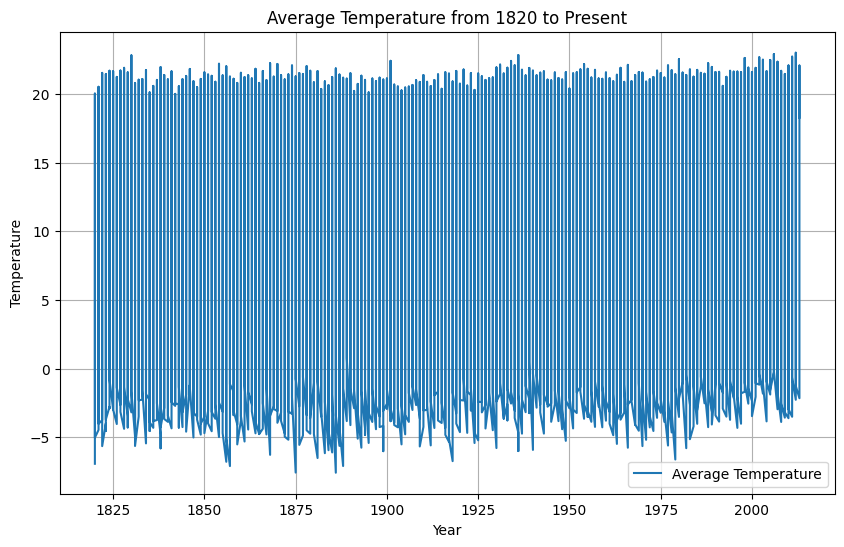

In [17]:
us_temp["dt"] = pd.to_datetime(us_temp["dt"], format="%Y-%m-%d")
us_temp["year"] = us_temp["dt"].dt.year
us_temp["month"] = us_temp["dt"].dt.month
us_temp_reindexed = us_temp.set_index("year")
us_temp_reindexed["AverageTemperature"] = us_temp_reindexed["AverageTemperature"].interpolate(method='linear')
us_temp_reindexed = us_temp_reindexed.reset_index()

plt.figure(figsize=(10, 6))
plt.plot(us_temp_reindexed['year'], us_temp_reindexed['AverageTemperature'], label='Average Temperature')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Average Temperature from 1820 to Present')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
us_temp['t'] = range(len(us_temp))

In [19]:
pre = us_temp[us_temp['year'] < 1920]
post = us_temp[us_temp['year'] >= 1920]

In [20]:
us_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,year,month,t
555496,1820-01-01,-6.929,0.733914,United States,1820,1,0
555497,1820-02-01,-2.158,0.563967,United States,1820,2,1
555498,1820-03-01,1.227,0.421650,United States,1820,3,2
555499,1820-04-01,8.978,0.374338,United States,1820,4,3
555500,1820-05-01,13.647,0.380394,United States,1820,5,4


In [21]:
us_temp.tail()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,year,month,t
557816,2013-05-01,14.073,0.023656,United States,2013,5,2320
557817,2013-06-01,20.198,0.034633,United States,2013,6,2321
557818,2013-07-01,22.074,0.018736,United States,2013,7,2322
557819,2013-08-01,21.168,0.037093,United States,2013,8,2323
557820,2013-09-01,18.273,0.218963,United States,2013,9,2324


Helper Functions

In [22]:
# helper functions to support the analysis

def ZeroSumNormal(name, *, sigma=None, active_dims=None, dims, model=None):
    model = pm.modelcontext(model=model)

    if isinstance(dims, str):
        dims = [dims]

    if isinstance(active_dims, str):
        active_dims = [active_dims]

    if active_dims is None:
        active_dims = dims[-1]

    def extend_axis(value, axis):
        n_out = value.shape[axis] + 1
        sum_vals = value.sum(axis, keepdims=True)
        norm = sum_vals / (pt.sqrt(n_out) + n_out)
        fill_val = norm - sum_vals / pt.sqrt(n_out)
        out = pt.concatenate([value, fill_val], axis=axis)
        return out - norm

    dims_reduced = []
    active_axes = []
    for i, dim in enumerate(dims):
        if dim in active_dims:
            active_axes.append(i)
            dim_name = f"{dim}_reduced"
            if name not in model.coords:
                model.coords(dim_name, length=len(model.coords[dim]) - 1, mutable=False)
            dims_reduced.append(dim_name)
        else:
            dims_reduced.append(dim)

    raw = pm.Normal(f"{name}_raw", sigma=sigma, dims=dims_reduced)
    for axis in active_axes:
        raw = extend_axis(raw, axis)
    return pm.Deterministic(name, raw, dims=dims)


def format_x_axis(ax, minor=False):
    # major ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(which="major", linestyle="-", axis="x")
    # minor ticks
    if minor:
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(which="minor", linestyle=":", axis="x")
    # rotate labels
    for label in ax.get_xticklabels(which="both"):
        label.set(rotation=70, horizontalalignment="right")


def plot_xY(x, Y, ax, label=''):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3, label=label)


# default figure sizes
figsize = (10, 5)

import calendar
import os
# create a list of month strings, for plotting purposes
month_strings = calendar.month_name[1:]

In [23]:
us_temp['pre'] = us_temp['year'] < 1920


In [24]:
us_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,year,month,t,pre
555496,1820-01-01,-6.929,0.733914,United States,1820,1,0,True
555497,1820-02-01,-2.158,0.563967,United States,1820,2,1,True
555498,1820-03-01,1.227,0.421650,United States,1820,3,2,True
555499,1820-04-01,8.978,0.374338,United States,1820,4,3,True
555500,1820-05-01,13.647,0.380394,United States,1820,5,4,True


<ipython-input-25-bdf60d1e87da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre['Year'] = pd.to_datetime(pre["dt"], format="%Y-%m-%d").dt.year


<Axes: xlabel='year', ylabel='AverageTemperature'>

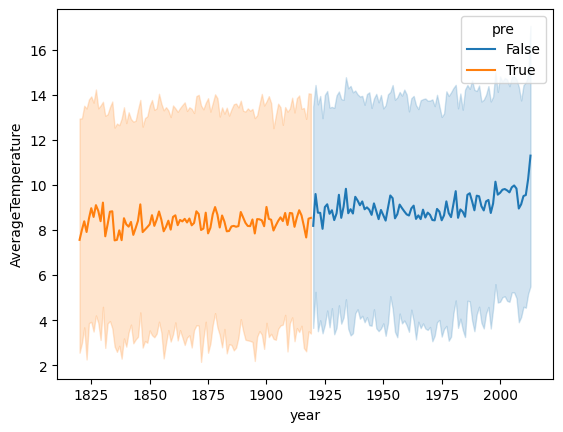

In [25]:
pre['Year'] = pd.to_datetime(pre["dt"], format="%Y-%m-%d").dt.year
ax = sns.lineplot(data=us_temp, x="year", y="AverageTemperature", hue="pre")
ax

#EDA PT. 2

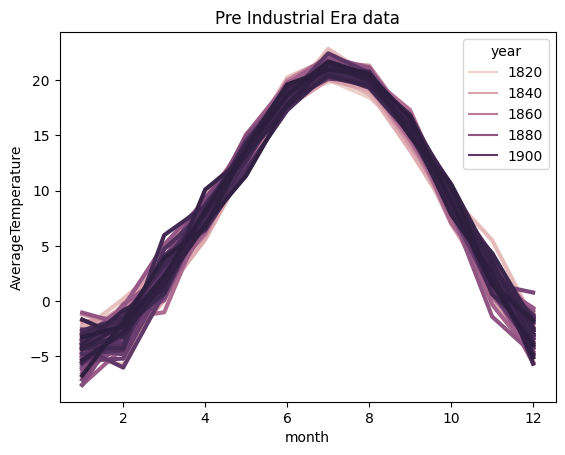

In [26]:
ax = sns.lineplot(data=pre, x="month", y="AverageTemperature", hue="year", lw=3)
ax.set(title="Pre Industrial Era data");

In [27]:
us_temp["Year"] = us_temp["dt"].dt.year

In [28]:
us_temp.set_index('dt', inplace=True)
us_temp['dt_column'] = us_temp.index  # Create a separate column 'dt_column' with the 'dt' values

In [29]:
us_temp.head()

,AverageTemperature,AverageTemperatureUncertainty,Country,year,month,t,pre,Year,dt_column
dt,,,,,,,,,
1820-01-01,-6.929,0.733914,United States,1820,1,0,True,1820,1820-01-01
1820-02-01,-2.158,0.563967,United States,1820,2,1,True,1820,1820-02-01
1820-03-01,1.227,0.421650,United States,1820,3,2,True,1820,1820-03-01
1820-04-01,8.978,0.374338,United States,1820,4,3,True,1820,1820-04-01
1820-05-01,13.647,0.380394,United States,1820,5,4,True,1820,1820-05-01


In [30]:
us_temp.columns

Index(['AverageTemperature', 'AverageTemperatureUncertainty', 'Country',
       'year', 'month', 't', 'pre', 'Year', 'dt_column'],
      dtype='object')

In [31]:
pre.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,year,month,t,Year
555496,1820-01-01,-6.929,0.733914,United States,1820,1,0,1820
555497,1820-02-01,-2.158,0.563967,United States,1820,2,1,1820
555498,1820-03-01,1.227,0.421650,United States,1820,3,2,1820
555499,1820-04-01,8.978,0.374338,United States,1820,4,3,1820
555500,1820-05-01,13.647,0.380394,United States,1820,5,4,1820


In [32]:
post['Year'] = pd.to_datetime(post["dt"], format="%Y-%m-%d").dt.year


<ipython-input-32-d85f6e41aeca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post['Year'] = pd.to_datetime(post["dt"], format="%Y-%m-%d").dt.year


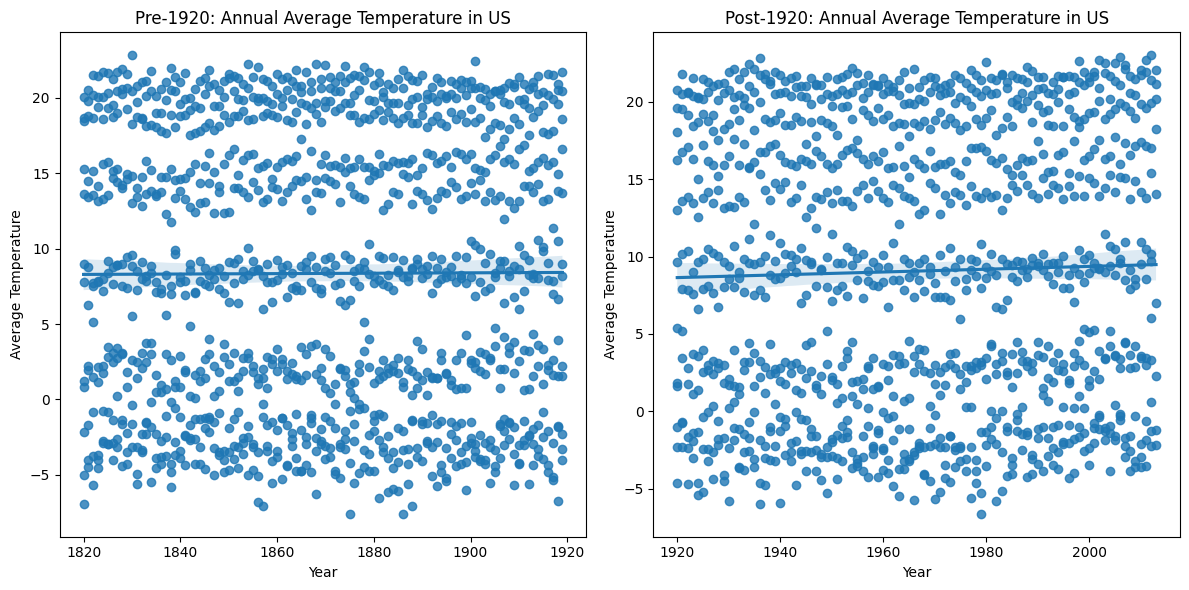

In [33]:
# Creating regression plots for pre-1840 and post-1840 periods
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.regplot(x='Year', y='AverageTemperature', data=pre)
plt.title('Pre-1920: Annual Average Temperature in US')
plt.xlabel('Year')
plt.ylabel('Average Temperature')

plt.subplot(1, 2, 2)
sns.regplot(x='Year', y='AverageTemperature', data=post)
plt.title('Post-1920: Annual Average Temperature in US')
plt.xlabel('Year')
plt.ylabel('Average Temperature')

plt.tight_layout()
plt.show()

#Bayesian Modeling

In [34]:
us_temp.head()

,AverageTemperature,AverageTemperatureUncertainty,Country,year,month,t,pre,Year,dt_column
dt,,,,,,,,,
1820-01-01,-6.929,0.733914,United States,1820,1,0,True,1820,1820-01-01
1820-02-01,-2.158,0.563967,United States,1820,2,1,True,1820,1820-02-01
1820-03-01,1.227,0.421650,United States,1820,3,2,True,1820,1820-03-01
1820-04-01,8.978,0.374338,United States,1820,4,3,True,1820,1820-04-01
1820-05-01,13.647,0.380394,United States,1820,5,4,True,1820,1820-05-01


In [35]:
pre.set_index('dt', inplace=True)
pre['dt_column'] = pre.index
post.set_index('dt', inplace=True)
post['dt_column'] = post.index

<ipython-input-35-5ba09ca1842e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre['dt_column'] = pre.index
<ipython-input-35-5ba09ca1842e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post['dt_column'] = post.index


In [36]:
pre.head()

,AverageTemperature,AverageTemperatureUncertainty,Country,year,month,t,Year,dt_column
dt,,,,,,,,
1820-01-01,-6.929,0.733914,United States,1820,1,0,1820,1820-01-01
1820-02-01,-2.158,0.563967,United States,1820,2,1,1820,1820-02-01
1820-03-01,1.227,0.421650,United States,1820,3,2,1820,1820-03-01
1820-04-01,8.978,0.374338,United States,1820,4,3,1820,1820-04-01
1820-05-01,13.647,0.380394,United States,1820,5,4,1820,1820-05-01


In [37]:
us_temp.describe()

,AverageTemperature,AverageTemperatureUncertainty,year,month,t,Year
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.00000,2325.000000
mean,8.695539,0.119756,1916.375484,6.494194,1162.00000,1916.375484
std,8.964368,0.140016,55.942931,3.451107,671.31401,55.942931
min,-7.581000,0.000000,1820.000000,1.000000,0.00000,1820.000000
25%,0.337000,0.022710,1868.000000,3.000000,581.00000,1868.000000
50%,8.676000,0.045799,1916.000000,6.000000,1162.00000,1916.000000
75%,17.528000,0.191143,1965.000000,9.000000,1743.00000,1965.000000
max,23.008000,0.949659,2013.000000,12.000000,2324.00000,2013.000000


In [38]:
pre["month"].shape

(1200,)

In [39]:
pre.head()

,AverageTemperature,AverageTemperatureUncertainty,Country,year,month,t,Year,dt_column
dt,,,,,,,,
1820-01-01,-6.929,0.733914,United States,1820,1,0,1820,1820-01-01
1820-02-01,-2.158,0.563967,United States,1820,2,1,1820,1820-02-01
1820-03-01,1.227,0.421650,United States,1820,3,2,1820,1820-03-01
1820-04-01,8.978,0.374338,United States,1820,4,3,1820,1820-04-01
1820-05-01,13.647,0.380394,United States,1820,5,4,1820,1820-05-01


In [40]:
random_seed= 8927
figsize= (10,6)

In [41]:
def ZeroSumNormal(name, *, sigma=None, active_dims=None, dims=None, model=None):
    model = pm.modelcontext(model=model)

    if isinstance(dims, str):
        dims = [dims]

    if isinstance(active_dims, str):
        active_dims = [active_dims]

    if active_dims is None:
        active_dims = dims[-1]

    def extend_axis(value, axis):
        n_out = value.shape[axis] + 1
        sum_vals = value.sum(axis, keepdims=True)
        norm = sum_vals / (pt.sqrt(n_out) + n_out)
        fill_val = norm - sum_vals / pt.sqrt(n_out)
        out = pt.concatenate([value, fill_val], axis=axis)
        return out - norm

    dims_reduced = []
    active_axes = []
    for i, dim in enumerate(dims):
        if dim in active_dims:
            active_axes.append(i)
            dim_name = f"{dim}_reduced"
            if name not in model.coords:
                model.add_coords(dim_name, length=len(model.coords[dim]) - 1, mutable=False)
            dims_reduced.append(dim_name)
        else:
            dims_reduced.append(dim)

    raw = pm.Normal(f"{name}_raw", sigma=sigma, dims=dims_reduced)
    for axis in active_axes:
        raw = extend_axis(raw, axis)
    return pm.Deterministic(name, raw, dims=dims)


In [42]:
import theano.tensor as tt
class ZeroSumNormal(pm.Continuous):
    def __init__(self, mu=0, sigma=None, *args, **kwargs):
        super(ZeroSumNormal, self).__init__(*args, **kwargs)
        self.mu = mu
        self.sigma = sigma
        self.mean = 0  # Ensure the distribution is centered around zero

    def random(self, point=None, size=None):
        mu = self.mu
        sigma = self.sigma
        return np.random.normal(mu, sigma, size)

    def logp(self, value):
        sigma = self.sigma
        return tt.sum(pm.Normal.dist(self.mu, sigma).logp(value))  # Constrain the sum of values close to zero


In [101]:

# Define the Fourier series for seasonality
def fourier_series(x, n_terms=10):
    series = []
    for i in range(1, n_terms + 1):
        series.append(np.sin(2 * i * np.pi * x / 12))
        series.append(np.cos(2 * i * np.pi * x / 12))
    return np.asarray(series).T


with pm.Model(coords={"t": pre["t"], "seasonality_terms": range(1, 21)}) as industrial:
    # observed predictors and outcome
    month = pm.Data("month", pre["month"].to_numpy())
    time = pm.Data("time", pre["t"].to_numpy())
    avgtemp = pm.Data("avgtemp", pre["AverageTemperature"].to_numpy())

    # priors
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    month_mu = ZeroSumNormal("month_mu", mu=0, sigma=1)  # Assuming ZeroSumNormal is defined

    linear_trend = pm.TruncatedNormal("linear_trend", -7, 23, lower=0)  # Adjusted prior for trend

    seasonality = pm.Data("seasonality", fourier_series(pre["t"]), dims=("t", "seasonality_terms"))

    # Fourier series coefficients for seasonality
    seasonality_coeff = pm.Normal("seasonality_coeff", mu=0, sigma=1, dims=("seasonality_terms",))
    temp_coeff = pm.Normal("temp coeff", 0, 30)

    # the actual linear model with seasonality
    seasonal_effect = pm.math.dot(seasonality, seasonality_coeff)
    mu = pm.Deterministic("mu", intercept + seasonal_effect + (month_mu*month)+ linear_trend)
    sigma = pm.HalfNormal("sigma", 1)

    # likelihood
    pm.Normal("obs", mu=mu, sigma=sigma, observed=avgtemp)

    # Prior predictive samples
    prior_trace = pm.sample_prior_predictive()
    g = pm.model_to_graphviz()


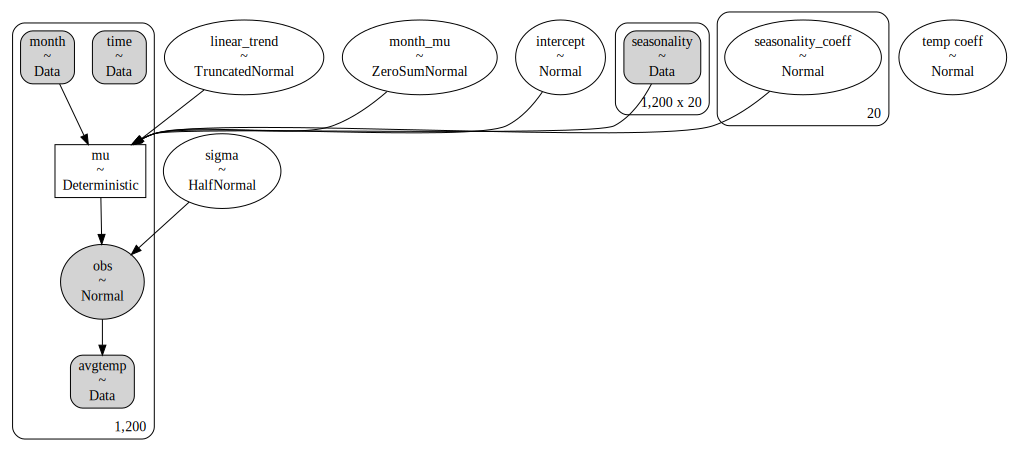

In [44]:
    g.render("industrial_model", format="png", cleanup =True)


In [45]:
random_seed= 1234

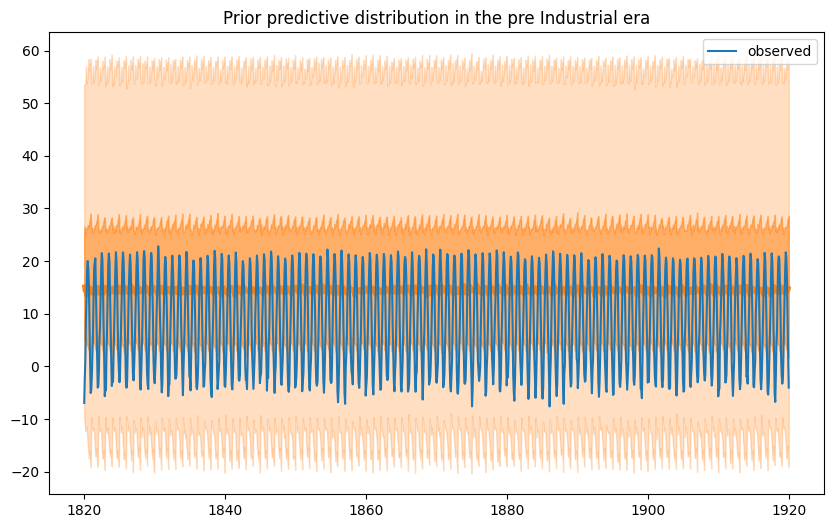

In [46]:
def plot_xY(x, Y, ax, label=''):
    percentiles = np.percentile(Y, q=(2.5, 25, 50, 75, 97.5), axis=0)

    ax.plot(x, percentiles[2], color="C1", lw=3, label=label)  # Median
    ax.fill_between(x, percentiles[0], percentiles[4], alpha=0.25, color="C1")  # 95% interval
    ax.fill_between(x, percentiles[1], percentiles[3], alpha=0.5, color="C1")  # 50% interval


fig, ax = plt.subplots(figsize=figsize)

plot_xY(pre.index, prior_trace["obs"], ax)
ax.plot(pre.index, pre["AverageTemperature"], label="observed")

ax.set(title="Prior predictive distribution in the pre Industrial era")
plt.legend();

In [47]:
# Group data by year
yearly_data = us_temp.groupby("Year")

# Find maximum and minimum temperatures for each year
pre2 = yearly_data["AverageTemperature"].max().reset_index(name="MaximumTemperature")
post2 = yearly_data["AverageTemperature"].min().reset_index(name="MinimumTemperature")


In [49]:
'''# Define a function to extract yearly max/min temperatures
def year_extremes(df):
    yearly_max = df.groupby("Year")["AverageTemperature"].max()
    yearly_min = df.groupby("Year")["AverageTemperature"].min()
    return pd.DataFrame({"Year": yearly_max.index, "MaxTemp": yearly_max, "MinTemp": yearly_min})

# Create a new pre-processing step
pre2 = year_extremes(us_temp)
'''


'# Define a function to extract yearly max/min temperatures\ndef year_extremes(df):\n    yearly_max = df.groupby("Year")["AverageTemperature"].max()\n    yearly_min = df.groupby("Year")["AverageTemperature"].min()\n    return pd.DataFrame({"Year": yearly_max.index, "MaxTemp": yearly_max, "MinTemp": yearly_min})\n\n# Create a new pre-processing step\npre2 = year_extremes(us_temp)\n'

In [50]:
def get_min_max_temperature_rows(df, year_column="year", temperature_column="AverageTemperature"):
    min_rows = df.groupby(year_column)[temperature_column].idxmin()
    max_rows = df.groupby(year_column)[temperature_column].idxmax()
    return pd.concat([df.loc[min_rows], df.loc[max_rows]], ignore_index=True)

# Create pre2 dataframe with min and max temperature rows for each year
pre2 = get_min_max_temperature_rows(pre, year_column="year", temperature_column="AverageTemperature")

# Reset index if needed (optional)
#
# Set the year column as the new index
pre2 = pre2.set_index("year")

# Ensure increasing order (optional)
pre2 = pre2.sort_index(ascending=True)# Print the new dataframe
pre2.head()



,AverageTemperature,AverageTemperatureUncertainty,Country,month,t,Year,dt_column
year,,,,,,,
1820,-6.929,0.733914,United States,1,0,1820,1820-01-01
1820,20.031,0.319076,United States,7,6,1820,1820-07-01
1821,-4.464,0.682248,United States,1,12,1821,1821-01-01
1821,20.527,0.396669,United States,8,19,1821,1821-08-01
1822,-5.644,0.501893,United States,12,35,1822,1822-12-01


In [51]:
# Create pre2 dataframe with min and max temperature rows for each year
post2 = get_min_max_temperature_rows(post, year_column="year", temperature_column="AverageTemperature")

# Reset index if needed (optional)
#
# Set the year column as the new index
post2 = post2.set_index("year")

# Ensure increasing order (optional)
post2 = post2.sort_index(ascending=True)# Print the new dataframe
post2.head()

,AverageTemperature,AverageTemperatureUncertainty,Country,month,t,Year,dt_column
year,,,,,,,
1920,-4.624,0.052801,United States,1,1200,1920,1920-01-01
1920,20.752,0.038986,United States,7,1206,1920,1920-07-01
1921,21.784,0.059992,United States,7,1218,1921,1921-07-01
1921,-2.321,0.076836,United States,1,1212,1921,1921-01-01
1922,-4.678,0.069076,United States,1,1224,1922,1922-01-01


In [104]:
with pm.Model(coords={"t": pre2["t"], "seasonality_terms": range(1, 21)}) as industrial:
    # observed predictors and outcome
    month = pm.Data("month", pre2["month"].to_numpy())
    time = pm.Data("time", pre2["t"].to_numpy())
    avgtemp = pm.Data("avgtemp", pre2["AverageTemperature"].to_numpy())

    # priors
    intercept = pm.StudentT("intercept", mu=0, sigma=10, nu = 3,dims=("seasonality_terms",))
    month_mu = ZeroSumNormal("month_mu", mu=0, sigma=1)  # Assuming ZeroSumNormal is defined

    linear_trend = pm.TruncatedNormal("linear_trend", -7, 23, lower=0)  # Adjusted prior for trend

    seasonality = pm.Data("seasonality", fourier_series(pre2["t"]))

    # Fourier series coefficients for seasonality
    seasonality_coeff = pm.Normal("seasonality_coeff", mu=0, sigma=1, dims=("seasonality_terms",))
    temp_coeff = pm.Normal("temp coeff", 0, 30)

    # the actual linear model with seasonality
    seasonal_effect = pm.math.dot(seasonality, seasonality_coeff)
    mu = pm.Deterministic("mu", intercept + seasonal_effect + (month_mu*month)+ linear_trend)
    sigma = pm.HalfNormal("sigma", 1)

    # likelihood
    pm.Normal("obs", mu=mu, sigma=sigma, observed=avgtemp)

    # Prior predictive samples
    prior_trace2 = pm.sample_prior_predictive()
    trace = pm.sample(12000, tune=8000, step=pm.Metropolis())

    g = pm.model_to_graphviz()


ValueError: ignored

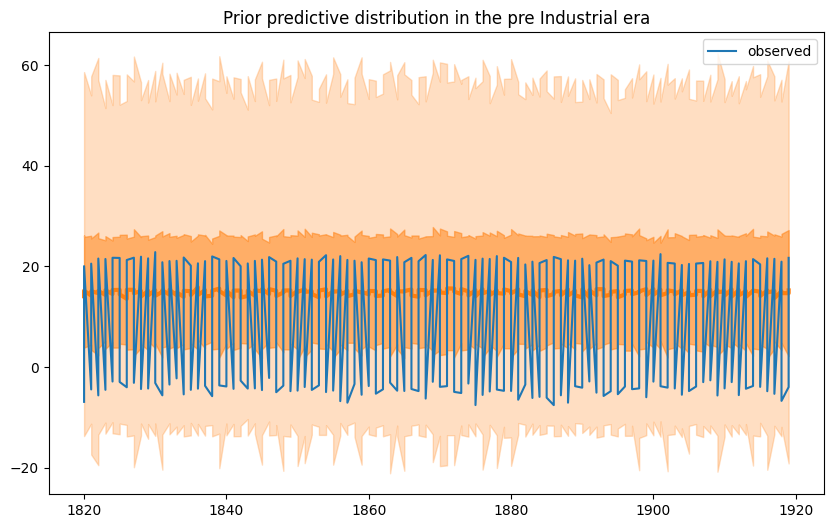

In [53]:
fig, ax = plt.subplots(figsize=figsize)

plot_xY(pre2.index, prior_trace2["obs"], ax)
ax.plot(pre2.index, pre2["AverageTemperature"], label="observed")

ax.set(title="Prior predictive distribution in the pre Industrial era")
plt.legend();

In [54]:
# Define function to filter max temperature rows
def filter_max_temperature(df, year_column="year", temperature_column="AverageTemperature"):
    max_rows = df.groupby(year_column)[temperature_column].idxmax()
    return df.loc[max_rows]

# Apply function to pre and store in pre3
pre3 = filter_max_temperature(pre, year_column="year", temperature_column="AverageTemperature")

# Apply function to post and store in post3
post3 = filter_max_temperature(post, year_column="year", temperature_column="AverageTemperature")

# Print the new dataframes (optional)
pre3.head()

,AverageTemperature,AverageTemperatureUncertainty,Country,year,month,t,Year,dt_column
dt,,,,,,,,
1820-07-01,20.031,0.319076,United States,1820,7,6,1820,1820-07-01
1821-08-01,20.527,0.396669,United States,1821,8,19,1821,1821-08-01
1822-07-01,21.539,0.288418,United States,1822,7,30,1822,1822-07-01
1823-07-01,21.453,0.289553,United States,1823,7,42,1823,1823-07-01
1824-07-01,21.696,0.554883,United States,1824,7,54,1824,1824-07-01


In [55]:
post3.head()

,AverageTemperature,AverageTemperatureUncertainty,Country,year,month,t,Year,dt_column
dt,,,,,,,,
1920-07-01,20.752,0.038986,United States,1920,7,1206,1920,1920-07-01
1921-07-01,21.784,0.059992,United States,1921,7,1218,1921,1921-07-01
1922-07-01,20.617,0.035958,United States,1922,7,1230,1922,1922-07-01
1923-07-01,21.530,0.028388,United States,1923,7,1242,1923,1923-07-01
1924-07-01,20.300,0.033687,United States,1924,7,1254,1924,1924-07-01


In [91]:
with pm.Model(coords={"t": pre3["t"], "seasonality_terms": range(1, 21)}) as industrial:
    # observed predictors and outcome
    month = pm.Data("month", pre3["month"].to_numpy())
    time = pm.Data("time", pre3["t"].to_numpy())
    avgtemp = pm.Data("avgtemp", pre3["AverageTemperature"].to_numpy())

    # priors
    intercept = pm.Normal("intercept", mu=0, sigma=15)
    month_mu = ZeroSumNormal("month_mu", mu=0, sigma=1)  # Assuming ZeroSumNormal is defined

    linear_trend = pm.TruncatedNormal("linear_trend", 0, 23, lower=0)  # Adjusted prior for trend

    seasonality = pm.Data("seasonality", fourier_series(pre3["t"]), dims=("t", "seasonality_terms"))

    # Fourier series coefficients for seasonality
    seasonality_coeff = pm.Normal("seasonality_coeff", mu=0, sigma=1.5, dims=("seasonality_terms",))
    temp_coeff = pm.Normal("temp coeff", 0, 30)

    # the actual linear model with seasonality
    seasonal_effect = pm.math.dot(seasonality, seasonality_coeff)
    mu = pm.Deterministic("mu", intercept + seasonal_effect + (month_mu*month)+ linear_trend)
    sigma = pm.HalfNormal("sigma", 1)

    # likelihood
    pm.Normal("obs", mu=mu, sigma=sigma, observed=avgtemp)

    trace = pm.sample(12000, tune= 8000, step=pm.NUTS())

    # Prior predictive samples
    prior_trace3 = pm.sample_prior_predictive()


    g = pm.model_to_graphviz()

/usr/local/lib/python3.10/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


ERROR:pymc3:There were 10034 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 7852 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 6361 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 6306 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [92]:
az.summary(trace)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,12.856,6.669,-0.546,24.642,0.719,0.510,82.0,266.0,1.09
month_mu,0.403,0.814,-1.166,1.900,0.088,0.062,92.0,920.0,1.03
seasonality_coeff[1],0.454,1.594,-2.476,2.961,0.379,0.272,20.0,117.0,1.15
seasonality_coeff[2],-0.105,1.420,-2.515,2.819,0.204,0.145,48.0,194.0,1.09
seasonality_coeff[3],-0.348,1.464,-2.946,2.405,0.286,0.204,26.0,67.0,1.10
...,...,...,...,...,...,...,...,...,...
mu[96],21.222,0.057,21.119,21.330,0.000,0.000,28736.0,25484.0,1.00
mu[97],21.222,0.057,21.119,21.330,0.000,0.000,28736.0,25484.0,1.00
mu[98],21.222,0.057,21.119,21.330,0.000,0.000,28736.0,25484.0,1.00
mu[99],21.222,0.057,21.119,21.330,0.000,0.000,28736.0,25484.0,1.00


In [93]:
with pm.Model(coords={"t": pre3["t"], "seasonality_terms": range(1, 21)}) as industrial:
    # observed predictors and outcome
    month = pm.Data("month", pre3["month"].to_numpy())
    time = pm.Data("time", pre3["t"].to_numpy())
    avgtemp = pm.Data("avgtemp", pre3["AverageTemperature"].to_numpy())

    # priors
    intercept = pm.Normal("intercept", mu=0, sigma=15)
    month_mu = ZeroSumNormal("month_mu", mu=0, sigma=1)  # Assuming ZeroSumNormal is defined

    linear_trend = pm.TruncatedNormal("linear_trend", 0, 23, lower=0)  # Adjusted prior for trend

    seasonality = pm.Data("seasonality", fourier_series(pre3["t"]), dims=("t", "seasonality_terms"))

    # Fourier series coefficients for seasonality
    seasonality_coeff = pm.Normal("seasonality_coeff", mu=0, sigma=1.5, dims=("seasonality_terms",))
    temp_coeff = pm.Normal("temp coeff", 0, 30)

    # the actual linear model with seasonality
    seasonal_effect = pm.math.dot(seasonality, seasonality_coeff)
    mu = pm.Deterministic("mu", intercept + seasonal_effect + (month_mu*month)+ linear_trend)
    sigma = pm.HalfNormal("sigma", 1)

    # likelihood
    pm.Normal("obs", mu=mu, sigma=sigma, observed=avgtemp)

    trace = pm.sample(40000, tune= 30000, step=pm.Metropolis())

    # Prior predictive samples
    prior_trace3 = pm.sample_prior_predictive()

    g = pm.model_to_graphviz()

/usr/local/lib/python3.10/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/usr/local/lib/python3.10/dist-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [94]:
az.summary(trace)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,4.988,5.759,-2.856,16.127,2.613,1.972,5.0,28.0,2.08
month_mu,0.962,0.827,-0.071,2.765,0.367,0.283,6.0,15.0,1.68
seasonality_coeff[1],0.205,1.275,-1.973,2.617,0.319,0.230,16.0,53.0,1.23
seasonality_coeff[2],-0.182,1.573,-3.218,2.515,0.427,0.309,14.0,79.0,1.24
seasonality_coeff[3],0.195,1.300,-2.339,2.690,0.248,0.178,26.0,31.0,1.11
...,...,...,...,...,...,...,...,...,...
mu[96],21.222,0.055,21.117,21.324,0.000,0.000,90959.0,101993.0,1.00
mu[97],21.222,0.055,21.117,21.324,0.000,0.000,90959.0,101993.0,1.00
mu[98],21.222,0.055,21.117,21.324,0.000,0.000,90959.0,101993.0,1.00
mu[99],21.222,0.055,21.117,21.324,0.000,0.000,90959.0,101993.0,1.00


In [95]:
with pm.Model(coords={"t": pre3["t"], "seasonality_terms": range(1, 21)}) as industrial:
    # observed predictors and outcome
    month = pm.Data("month", pre3["month"].to_numpy())
    time = pm.Data("time", pre3["t"].to_numpy())
    avgtemp = pm.Data("avgtemp", pre3["AverageTemperature"].to_numpy())

    # priors
    intercept = pm.StudentT("intercept", mu=0, sigma=15, nu=3)  # Adjusted to t-distribution
    month_mu = ZeroSumNormal("month_mu", mu=0, sigma=1)  # Assuming ZeroSumNormal is defined

    linear_trend = pm.TruncatedNormal("linear_trend", 0, 23, lower=0)  # Adjusted prior for trend

    seasonality = pm.Data("seasonality", fourier_series(pre3["t"]), dims=("t", "seasonality_terms"))

    # Fourier series coefficients for seasonality
    seasonality_coeff = pm.StudentT("seasonality_coeff", mu=0, sigma=1.5, nu=3, dims=("seasonality_terms",))
    temp_coeff = pm.Normal("temp coeff", 0, 30)

    # the actual linear model with seasonality
    seasonal_effect = pm.math.dot(seasonality, seasonality_coeff)
    mu = pm.Deterministic("mu", intercept + seasonal_effect + (month_mu * month) + linear_trend)
    sigma = pm.HalfNormal("sigma", 1)

    # likelihood
    pm.Normal("obs", mu=mu, sigma=sigma, observed=avgtemp)

    trace = pm.sample(12000, tune=8000, step=pm.NUTS())

    # Prior predictive samples
    prior_trace3 = pm.sample_prior_predictive()

    g = pm.model_to_graphviz()


/usr/local/lib/python3.10/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


ERROR:pymc3:There were 9006 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 8510 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 9291 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 7306 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [96]:
az.summary(trace)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,9.878,6.365,0.922,24.181,1.698,1.227,13.0,122.0,1.30
month_mu,0.294,0.802,-0.848,1.747,0.264,0.193,10.0,138.0,1.30
seasonality_coeff[1],-0.297,1.711,-2.871,2.755,0.310,0.222,16.0,154.0,1.24
seasonality_coeff[2],0.453,1.898,-2.827,2.821,0.507,0.366,12.0,83.0,1.31
seasonality_coeff[3],-0.645,1.793,-5.071,2.190,0.306,0.286,25.0,20.0,1.27
...,...,...,...,...,...,...,...,...,...
mu[96],21.222,0.054,21.118,21.318,0.000,0.000,17555.0,11092.0,1.00
mu[97],21.222,0.054,21.118,21.318,0.000,0.000,17555.0,11092.0,1.00
mu[98],21.222,0.054,21.118,21.318,0.000,0.000,17555.0,11092.0,1.00
mu[99],21.222,0.054,21.118,21.318,0.000,0.000,17555.0,11092.0,1.00


In [110]:
with pm.Model(coords={"t": pre3["t"], "seasonality_terms": range(1, 21)}) as industrial:
    # observed predictors and outcome
    month = pm.Data("month", pre3["month"].to_numpy())
    time = pm.Data("time", pre3["t"].to_numpy())
    avgtemp = pm.Data("avgtemp", pre3["AverageTemperature"].to_numpy())

    # priors
    intercept = pm.StudentT("intercept", mu=0, sigma=15, nu=3)  # Adjusted to t-distribution
    month_mu = ZeroSumNormal("month_mu", mu=0, sigma=1)  # Assuming ZeroSumNormal is defined

    linear_trend = pm.TruncatedNormal("linear_trend", 0, 23, lower=0)  # Adjusted prior for trend

    seasonality = pm.Data("seasonality", fourier_series(pre3["t"]), dims=("t", "seasonality_terms"))

    # Fourier series coefficients for seasonality
    seasonality_coeff = pm.StudentT("seasonality_coeff", mu=0, sigma=1.5, nu=3, dims=("seasonality_terms",))
    temp_coeff = pm.Normal("temp coeff", 0, 30)

    # the actual linear model with seasonality
    seasonal_effect = pm.math.dot(seasonality, seasonality_coeff)
    mu = pm.Deterministic("mu", intercept + seasonal_effect + (month_mu * month) + linear_trend)
    sigma = pm.HalfNormal("sigma", 1)

    # likelihood
    pm.Normal("obs", mu=mu, sigma=sigma, observed=avgtemp)

    trace = pm.sample(12000, tune=5000, step=pm.Slice())

    # Prior predictive samples
    prior_trace3 = pm.sample_prior_predictive()

    g = pm.model_to_graphviz()


/usr/local/lib/python3.10/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [111]:
az.summary(trace)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-6.362,9.663,-20.713,11.130,4.560,3.461,5.0,12.0,2.62
month_mu,-1.554,1.811,-5.165,0.827,0.854,0.650,5.0,11.0,2.60
seasonality_coeff[1],-12.276,42.849,-105.488,8.825,15.812,11.657,14.0,11.0,1.19
seasonality_coeff[2],13.515,17.489,-21.757,43.104,8.245,6.257,5.0,11.0,2.39
seasonality_coeff[3],138.531,166.689,-6.755,452.556,70.539,52.744,6.0,11.0,1.73
...,...,...,...,...,...,...,...,...,...
mu[96],21.222,0.055,21.117,21.324,0.000,0.000,47723.0,45043.0,1.00
mu[97],21.222,0.055,21.117,21.324,0.000,0.000,47723.0,45043.0,1.00
mu[98],21.222,0.055,21.117,21.324,0.000,0.000,47723.0,45043.0,1.00
mu[99],21.222,0.055,21.117,21.324,0.000,0.000,47723.0,45043.0,1.00


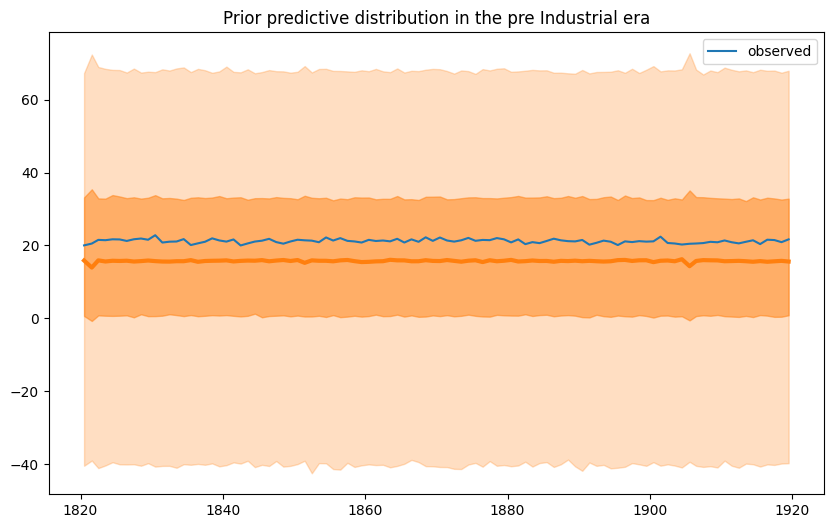

In [112]:
fig, ax = plt.subplots(figsize=figsize)

plot_xY(pre3.index, prior_trace3["obs"], ax)
ax.plot(pre3.index, pre3["AverageTemperature"], label="observed")

ax.set(title="Prior predictive distribution in the pre Industrial era")
plt.legend();

/usr/local/lib/python3.10/dist-packages/arviz/data/base.py:220: UserWarning: More chains (500) than draws (100). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/data/base.py:220: UserWarning: More chains (500) than draws (20). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/data/base.py:220: UserWarning: More chains (500) than draws (100). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/data/base.py:220: UserWarning: More chains (500) than draws (20). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-pac

AttributeError: ignored

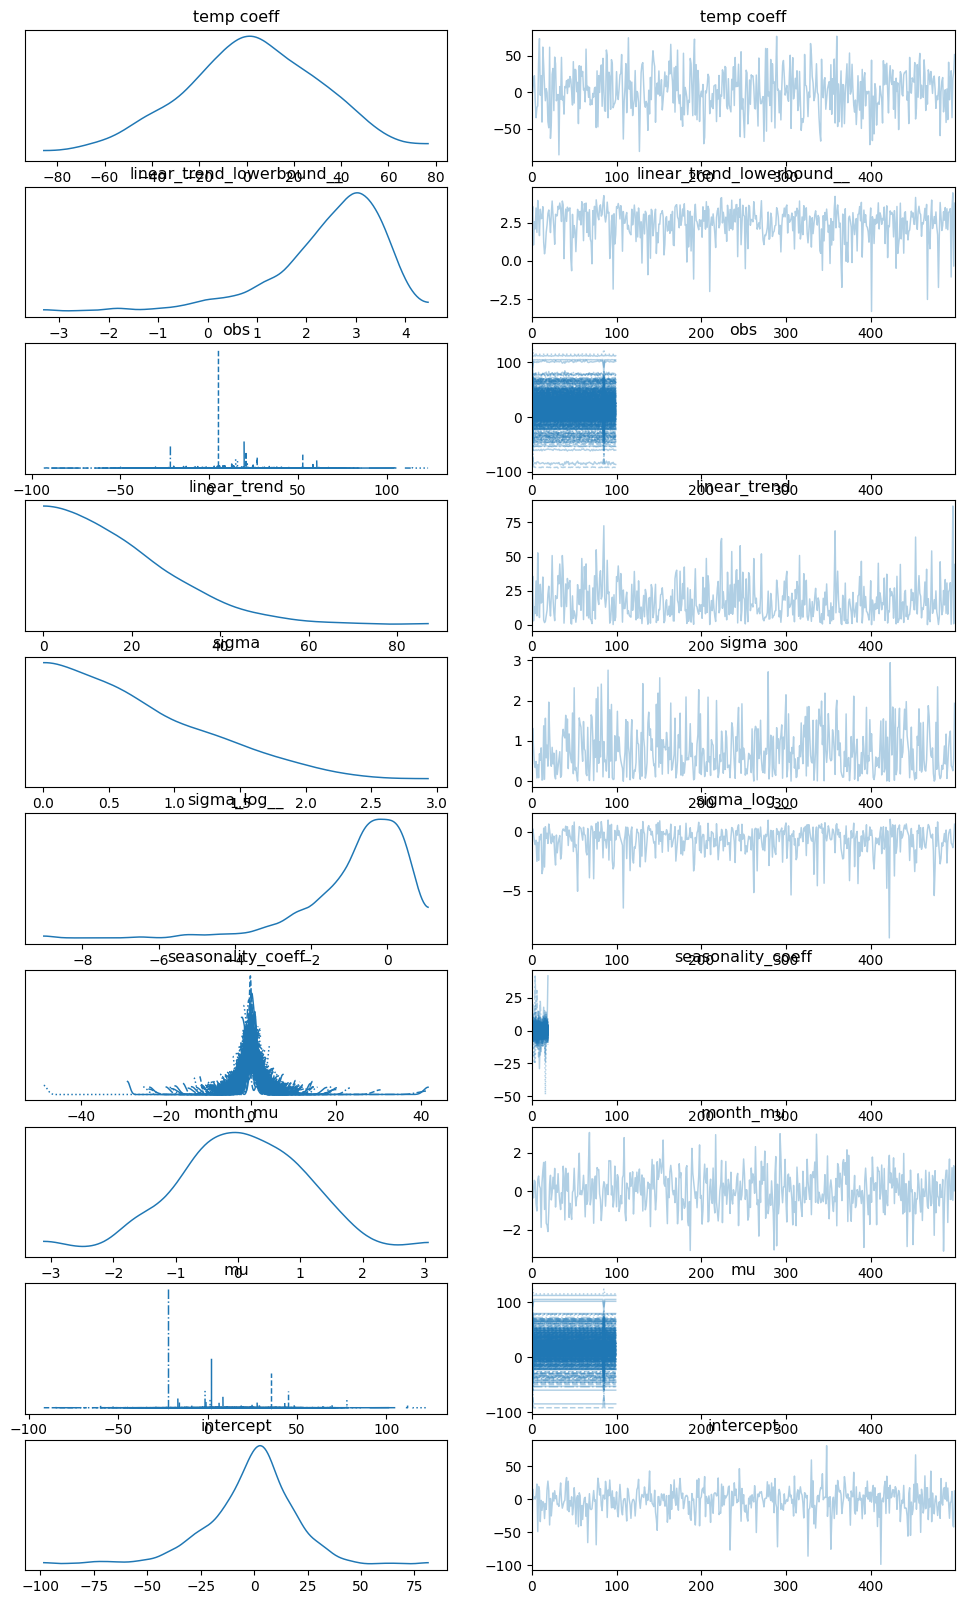

In [113]:
trace_plot = az.plot_trace(prior_trace3)
trace_plot.show()


In [118]:
# Assuming you've already defined your model and obtained the trace

with industrial:
    # Sampling from the posterior predictive distribution
    posterior_pred = pm.sample_posterior_predictive(trace, samples=500)


/usr/local/lib/python3.10/dist-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


ValueError: ignored

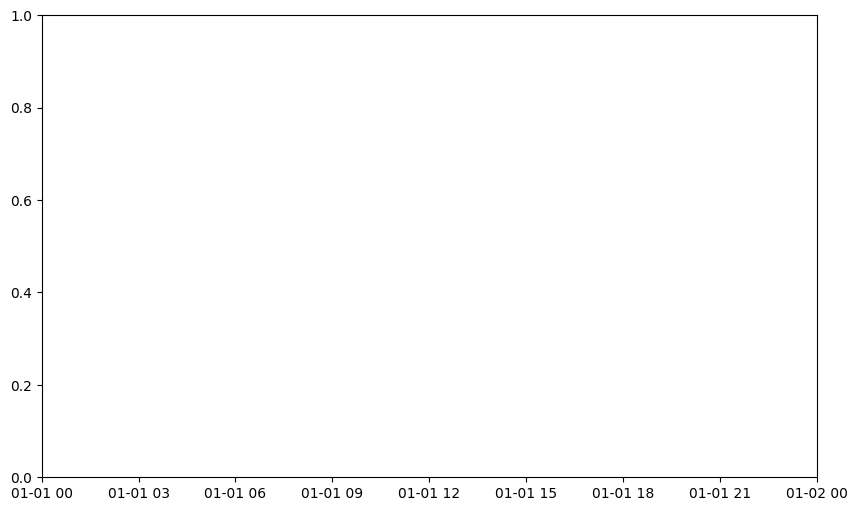

In [120]:
fig, ax = plt.subplots(figsize=figsize)

# Plotting the posterior predictive distribution
plot_xY(pre3.index, posterior_pred["obs"].mean(axis=0), ax)
ax.plot(pre3.index, pre3["AverageTemperature"], label="observed")

ax.set(title="Posterior predictive distribution in the pre-Industrial era")
plt.legend()
plt.show()